<a href="https://colab.research.google.com/github/JaeminBang/mp_course_examples/blob/master/HW12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

# 압축 파일 해제
with zipfile.ZipFile('UCI HAR Dataset.zip', 'r') as zip_ref:  # 'Dataset.zip'은 업로드한 파일의 이름입니다.
    zip_ref.extractall('dataset')  # 압축을 해제할 폴더 이름을 지정합니다.


Linear SVC + Hybrid SVM-kNN (6번 방식) 모델의 정확도: 0.9644


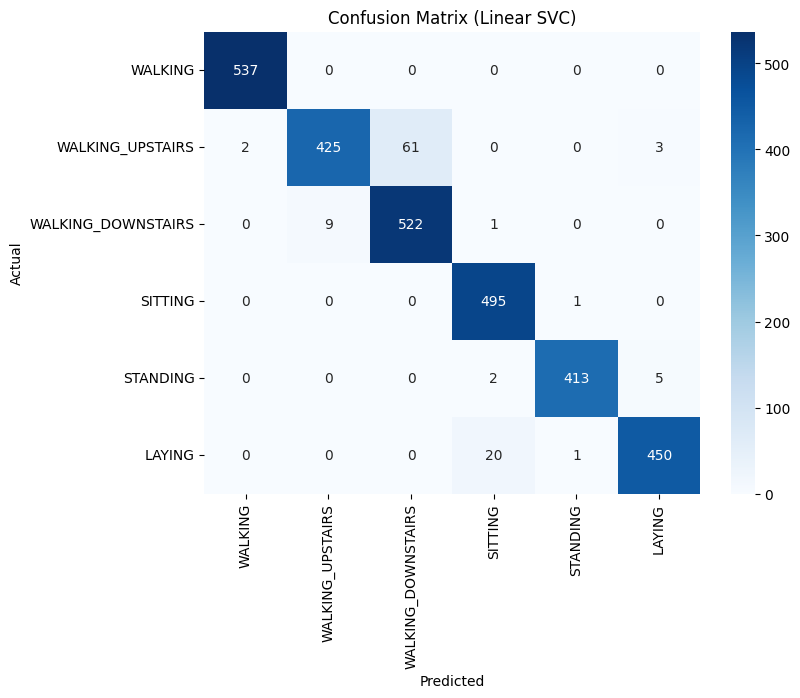

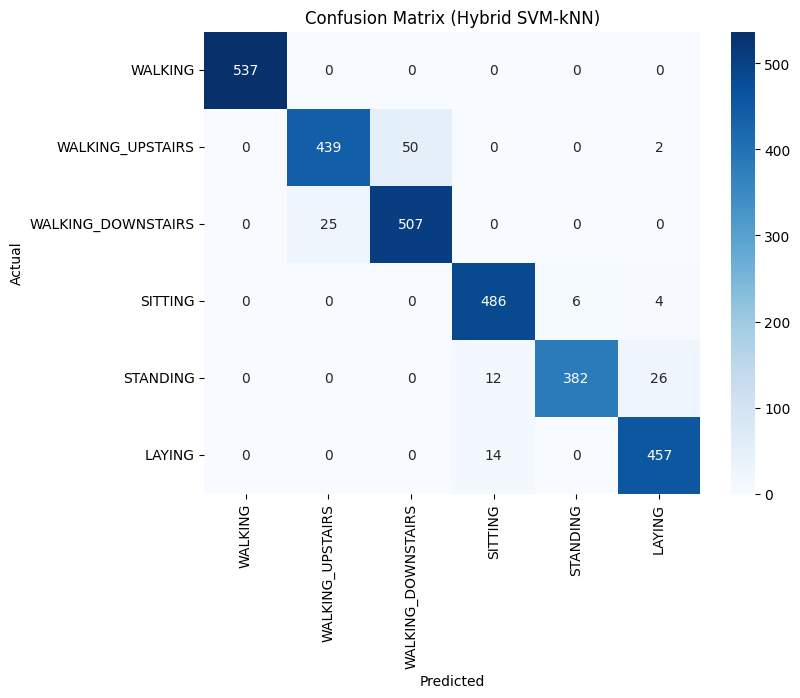

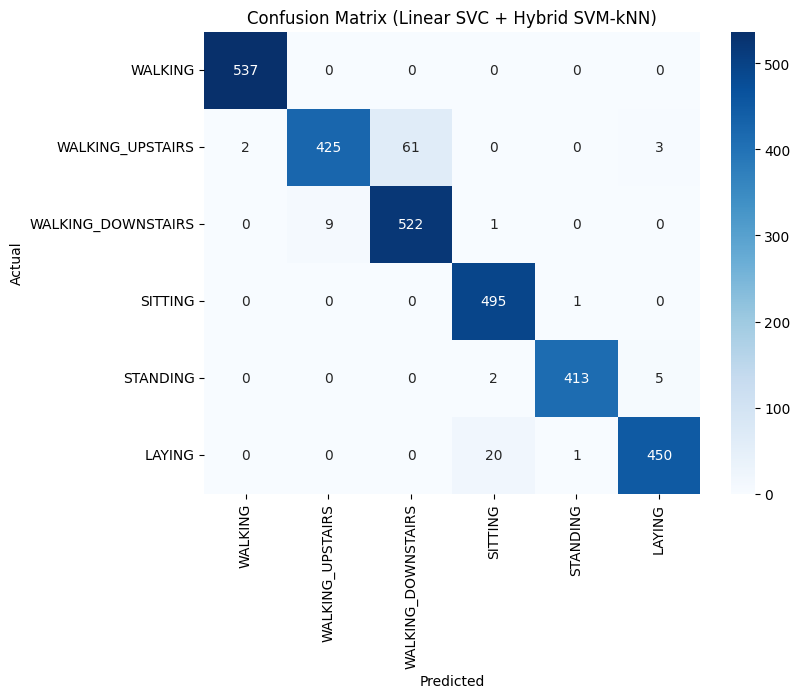

In [ ]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
features = pd.read_csv('./dataset/UCI HAR Dataset/features.txt', sep='\s+', header=None, names=['index', 'feature'])
feature_names = features['feature'].values  # 특징 이름 배열

activity_labels = pd.read_csv('./dataset/UCI HAR Dataset/activity_labels.txt', sep='\s+', header=None, names=['label', 'activity'])
activity_mapping = dict(activity_labels.values)  # 활동 번호와 이름 매핑

train_data = pd.read_csv('./dataset/UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None)
train_labels = pd.read_csv('./dataset/UCI HAR Dataset/train/y_train.txt', header=None, names=['label'])

test_data = pd.read_csv('./dataset/UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None)
test_labels = pd.read_csv('./dataset/UCI HAR Dataset/test/y_test.txt', header=None, names=['label'])

# 특징 이름 추가
train_data.columns = feature_names
test_data.columns = feature_names

# 라벨 이름 추가
train_data['Activity'] = train_labels['label'].map(activity_mapping)
test_data['Activity'] = test_labels['label'].map(activity_mapping)

# 데이터 확인
train_data.head(2)

# 훈련 데이터와 테스트 데이터 분리 (train_data와 test_data에서 이미 분리되어 있음)
X_train = train_data.iloc[:, :-1]  # 특징
y_train = train_data['Activity']   # 레이블

X_test = test_data.iloc[:, :-1]    # 특징
y_test = test_data['Activity']     # 레이블

# 데이터 스케일링 (Linear SVC는 스케일링하지 않음)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hybrid SVM-kNN 모델 구현 (6번 방식)
def hybrid_svm_knn_v6(X_train, y_train, X_test, y_test, k=5, svm_threshold=0.7):
    # Step 1: k-NN 초기 필터링
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_labels = knn.predict(X_test)

    # Step 2: SVM 학습 및 예측
    svm = SVC(kernel='rbf', C=1, probability=True, random_state=42)  # RBF 커널 사용
    svm.fit(X_train, y_train)
    svm_probs = svm.predict_proba(X_test)  # 클래스별 확률
    svm_labels = svm.predict(X_test)

    # Step 3: SVM 신뢰도 기반 조합
    final_labels = []
    for i in range(len(y_test)):
        if max(svm_probs[i]) >= svm_threshold:
            final_labels.append(svm_labels[i])  # SVM 신뢰도가 기준 이상이면 SVM 결과 사용
        else:
            final_labels.append(knn_labels[i])  # 아니면 k-NN 결과 사용

    return final_labels

# Linear SVC 모델 학습 및 예측
linear_svc = LinearSVC(C=1, max_iter=1000, tol=0.001, random_state=42)
linear_svc.fit(X_train, y_train)
linear_svc_labels = linear_svc.predict(X_test)

# Hybrid SVM-kNN 모델 학습 및 예측 (6번 방식)
hybrid_labels = hybrid_svm_knn_v6(X_train, y_train, X_test, y_test, k=5, svm_threshold=0.7)

# WALKING_UPSTAIRS에 해당하는 인덱스 추출
upstairs_label_index = list(activity_mapping.keys())[list(activity_mapping.values()).index("WALKING_UPSTAIRS")]  # WALKING_UPSTAIRS의 레이블 번호
upstairs_indices = np.where(y_test == upstairs_label_index)[0]

# Linear SVC와 Hybrid SVM 결과를 결합 (WALKING_UPSTAIRS는 Hybrid SVM 사용)
final_labels = np.array(linear_svc_labels)
final_labels[upstairs_indices] = np.array(hybrid_labels)[upstairs_indices]

# 정확도 계산
accuracy = accuracy_score(y_test, final_labels)
print(f"Linear SVC + Hybrid SVM-kNN (6번 방식) 모델의 정확도: {accuracy:.4f}")

# 혼동 행렬 계산 및 시각화 (Linear SVC)
cm_linear_svc = confusion_matrix(y_test, linear_svc_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_linear_svc, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Linear SVC)')
plt.show()

# 혼동 행렬 계산 및 시각화 (Hybrid SVM-kNN 모델)
cm_hybrid_svm = confusion_matrix(y_test, hybrid_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid_svm, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Hybrid SVM-kNN)')
plt.show()

# 혼동 행렬 계산 및 시각화 (Hybrid SVM-kNN + Linear SVC 모델)
cm_final = confusion_matrix(y_test, final_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Linear SVC + Hybrid SVM-kNN)')
plt.show()


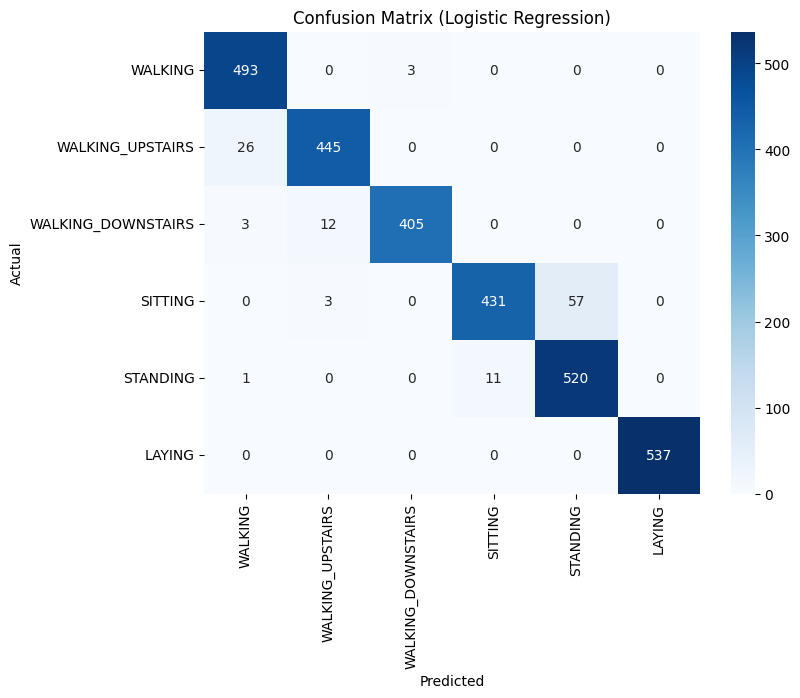

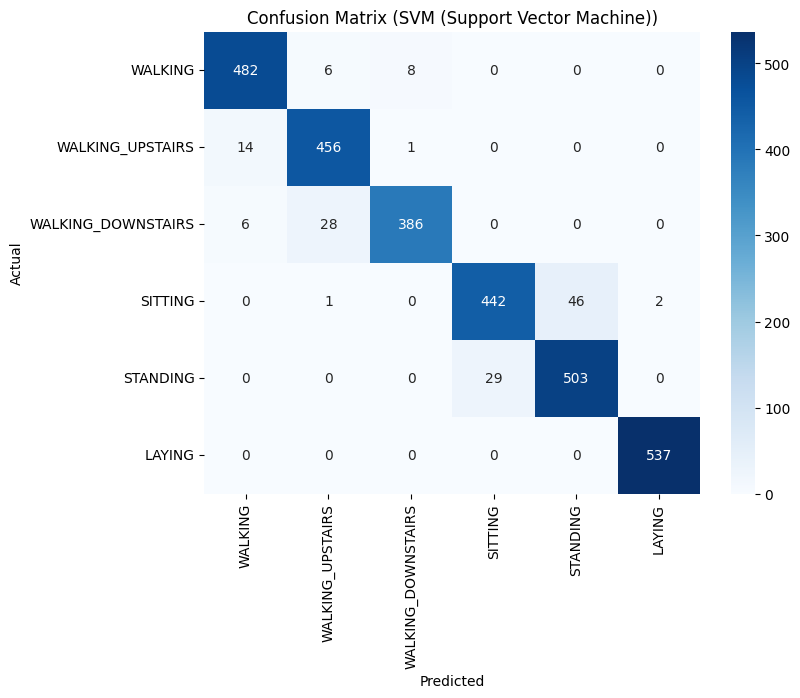

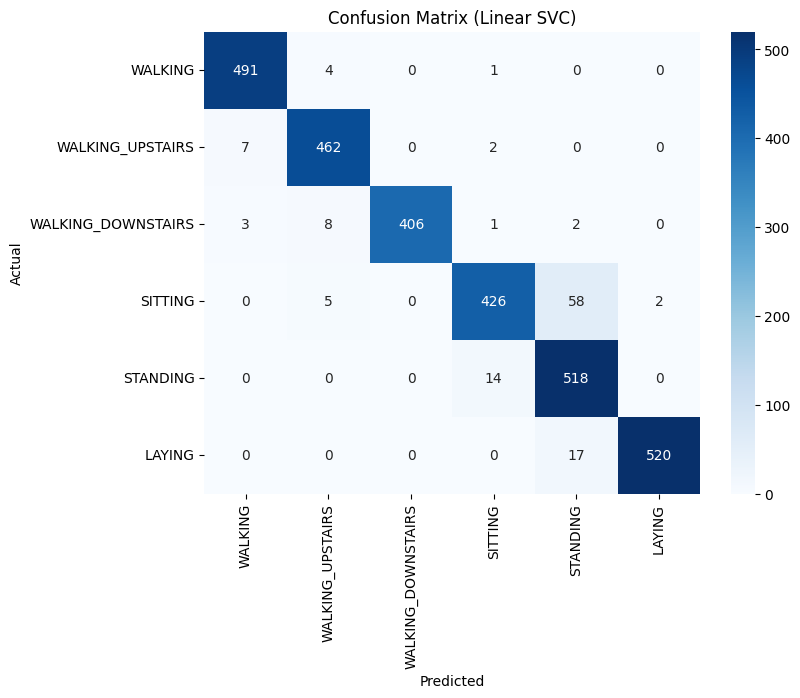

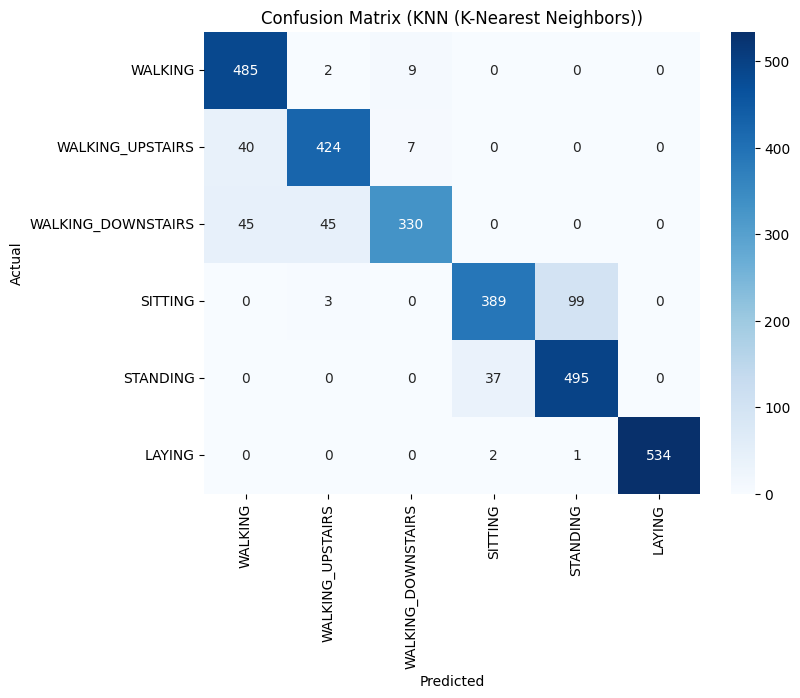

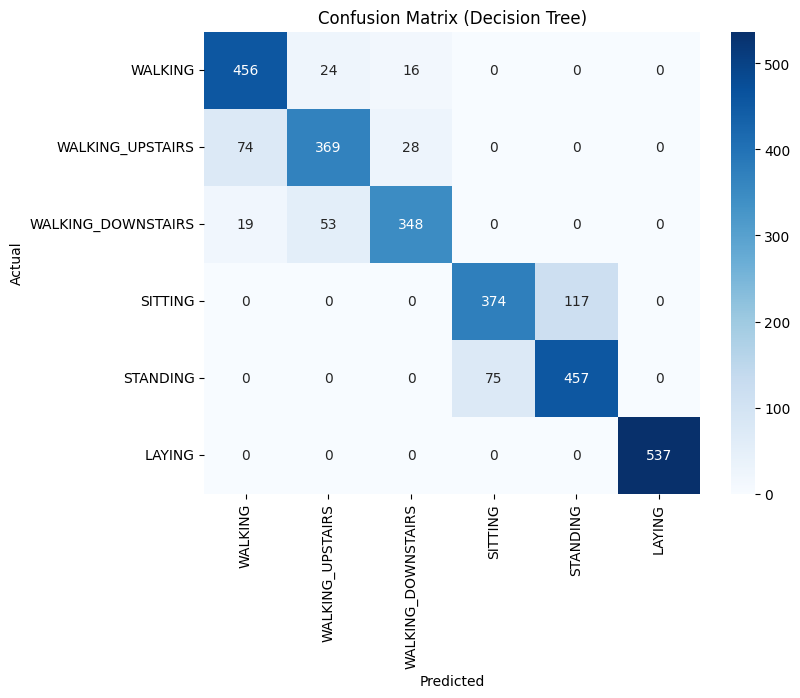

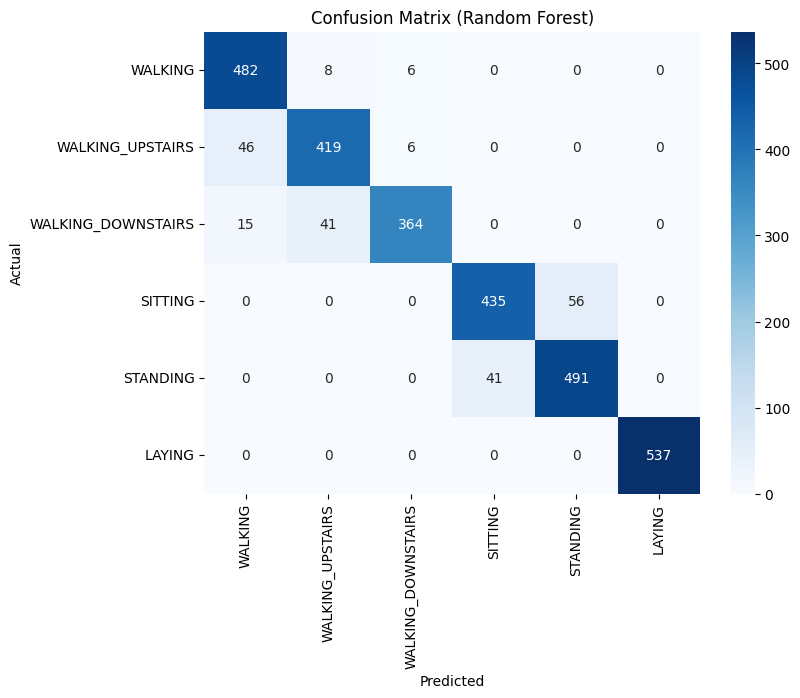

In [ ]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
features = pd.read_csv('./dataset/UCI HAR Dataset/features.txt', sep='\s+', header=None, names=['index', 'feature'])
feature_names = features['feature'].values  # 특징 이름 배열

activity_labels = pd.read_csv('./dataset/UCI HAR Dataset/activity_labels.txt', sep='\s+', header=None, names=['label', 'activity'])
activity_mapping = dict(activity_labels.values)  # 활동 번호와 이름 매핑

train_data = pd.read_csv('./dataset/UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None)
train_labels = pd.read_csv('./dataset/UCI HAR Dataset/train/y_train.txt', header=None, names=['label'])

test_data = pd.read_csv('./dataset/UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None)
test_labels = pd.read_csv('./dataset/UCI HAR Dataset/test/y_test.txt', header=None, names=['label'])

# 특징 이름 추가
train_data.columns = feature_names
test_data.columns = feature_names

# 라벨 이름 추가
train_data['Activity'] = train_labels['label'].map(activity_mapping)
test_data['Activity'] = test_labels['label'].map(activity_mapping)

# 라벨 값 분리
y_train = train_labels['label'].values
y_test = test_labels['label'].values

# 특징 값만 선택
X_train = train_data.drop(columns=['Activity']).values
X_test = test_data.drop(columns=['Activity']).values

# 데이터 스케일링 (Linear SVC 및 SVM 모델에 대해서는 스케일링 필요)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 리스트 정의
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM (Support Vector Machine)': SVC(random_state=42),
    'Linear SVC': LinearSVC(C=1, max_iter=1000, tol=0.001, random_state=42),
    'KNN (K-Nearest Neighbors)': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# 모델 학습, 예측 및 혼동 행렬 계산
for model_name, model in models.items():
    # 모델 학습
    if model_name in ['Linear SVC', 'SVM (Support Vector Machine)']:  # SVM 계열은 스케일링된 데이터 사용
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:  # 다른 모델은 스케일링된 데이터 사용하지 않음
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # 혼동 행렬 계산
    cm = confusion_matrix(y_test, y_pred)

    # 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.show()


Hybrid SVM-kNN (6번 방식) + Linear SVC (스케일링되지 않은 데이터) 모델의 전체 정확도: 0.9671


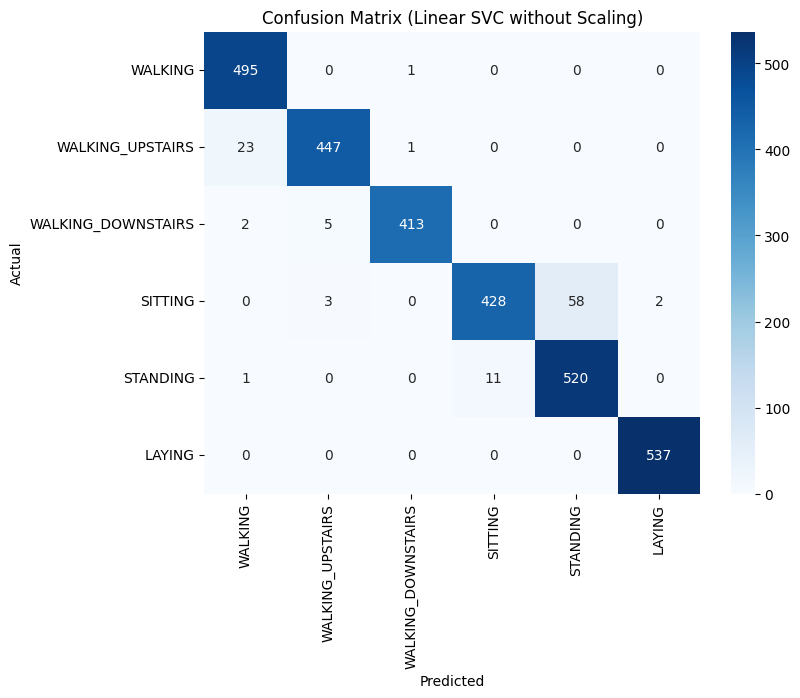

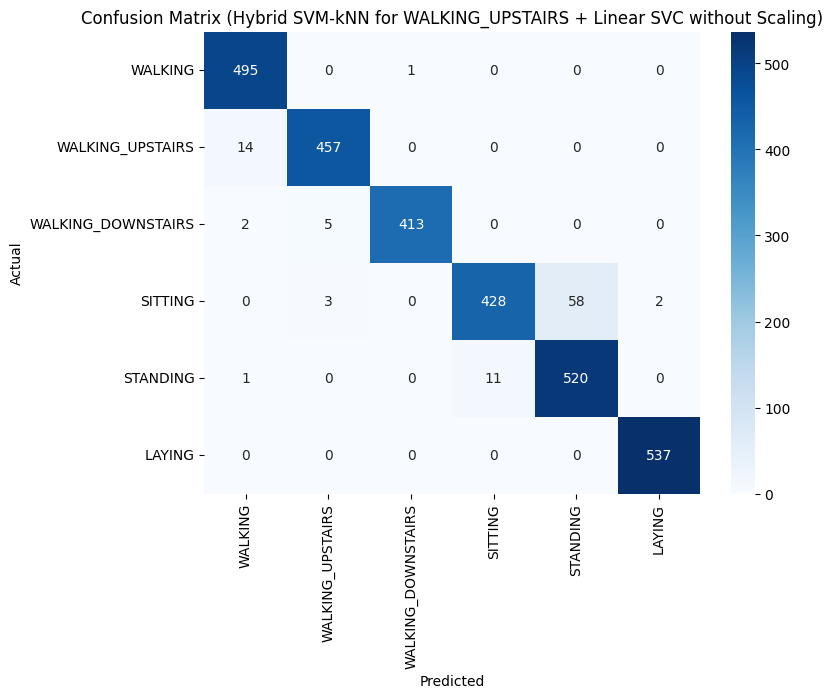

In [ ]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
features = pd.read_csv('./dataset/UCI HAR Dataset/features.txt', sep='\s+', header=None, names=['index', 'feature'])
feature_names = features['feature'].values  # 특징 이름 배열

activity_labels = pd.read_csv('./dataset/UCI HAR Dataset/activity_labels.txt', sep='\s+', header=None, names=['label', 'activity'])
activity_mapping = dict(activity_labels.values)  # 활동 번호와 이름 매핑

train_data = pd.read_csv('./dataset/UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None)
train_labels = pd.read_csv('./dataset/UCI HAR Dataset/train/y_train.txt', header=None, names=['label'])

test_data = pd.read_csv('./dataset/UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None)
test_labels = pd.read_csv('./dataset/UCI HAR Dataset/test/y_test.txt', header=None, names=['label'])

# 특징 이름 추가
train_data.columns = feature_names
test_data.columns = feature_names

# 라벨 이름 추가
train_data['Activity'] = train_labels['label'].map(activity_mapping)
test_data['Activity'] = test_labels['label'].map(activity_mapping)

# 라벨 값 분리
y_train = train_labels['label'].values
y_test = test_labels['label'].values

# 특징 값만 선택
X_train = train_data.drop(columns=['Activity']).values
X_test = test_data.drop(columns=['Activity']).values

# 데이터 스케일링
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Hybrid SVM-kNN 모델 구현 (6번 방식)
def hybrid_svm_knn_v6(X_train, y_train, X_test, y_test, k=5, svm_threshold=0.7):
    # Step 1: k-NN 초기 필터링
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_labels = knn.predict(X_test)

    # Step 2: SVM 학습 및 예측
    svm = SVC(kernel='rbf', C=1, probability=True, random_state=42)  # RBF 커널 사용
    svm.fit(X_train, y_train)
    svm_probs = svm.predict_proba(X_test)  # 클래스별 확률
    svm_labels = svm.predict(X_test)

    # Step 3: SVM 신뢰도 기반 조합
    final_labels = []
    for i in range(len(y_test)):
        if max(svm_probs[i]) >= svm_threshold:
            final_labels.append(svm_labels[i])  # SVM 신뢰도가 기준 이상이면 SVM 결과 사용
        else:
            final_labels.append(knn_labels[i])  # 아니면 k-NN 결과 사용

    # 정확도 계산
    accuracy = accuracy_score(y_test, final_labels)
    return accuracy, final_labels

# Linear SVC 모델 학습 및 예측 (스케일링하지 않은 데이터 사용)
linear_svc = LinearSVC(C=1, max_iter=1000, tol=0.001, random_state=42)
linear_svc.fit(train_data.drop(columns=['Activity']).values, y_train)  # 스케일링하지 않은 원본 데이터 사용
linear_svc_labels = linear_svc.predict(test_data.drop(columns=['Activity']).values)  # 스케일링하지 않은 데이터로 예측

# WALKING_UPSTAIRS에 대해서만 Hybrid SVM-kNN (6번 방식) 적용
_, hybrid_labels = hybrid_svm_knn_v6(X_train, y_train, X_test, y_test, k=5, svm_threshold=0.7)

# WALKING_UPSTAIRS에 해당하는 인덱스 추출
upstairs_label_index = list(activity_mapping.keys())[list(activity_mapping.values()).index("WALKING_UPSTAIRS")]  # WALKING_UPSTAIRS의 레이블 번호
upstairs_indices = np.where(y_test == upstairs_label_index)[0]

# Linear SVC 결과에 하이브리드 결과 반영
final_labels = np.array(linear_svc_labels)
final_labels[upstairs_indices] = np.array(hybrid_labels)[upstairs_indices]

# 정확도 계산
accuracy = accuracy_score(y_test, final_labels)
print(f"Hybrid SVM-kNN (6번 방식) + Linear SVC (스케일링되지 않은 데이터) 모델의 전체 정확도: {accuracy:.4f}")

# 혼동 행렬 계산 및 시각화

# 1. Linear SVC 혼동 행렬
cm_linear_svc = confusion_matrix(y_test, linear_svc_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_linear_svc, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Linear SVC without Scaling)')
plt.show()

# 2. Hybrid 모델 (Linear SVC + Hybrid SVM-kNN for WALKING_UPSTAIRS) 혼동 행렬
cm_hybrid = confusion_matrix(y_test, final_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Hybrid SVM-kNN for WALKING_UPSTAIRS + Linear SVC without Scaling)')
plt.show()


Linear SVC 모델의 정확도: 0.9667
Hybrid SVM-kNN 모델의 정확도: 0.9528
최종 모델의 정확도: 0.9698

분류 리포트:

                    precision    recall  f1-score   support

           WALKING       0.96      1.00      0.98       496
  WALKING_UPSTAIRS       0.98      0.97      0.98       471
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
           SITTING       0.94      0.93      0.93       491
          STANDING       0.94      0.94      0.94       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947



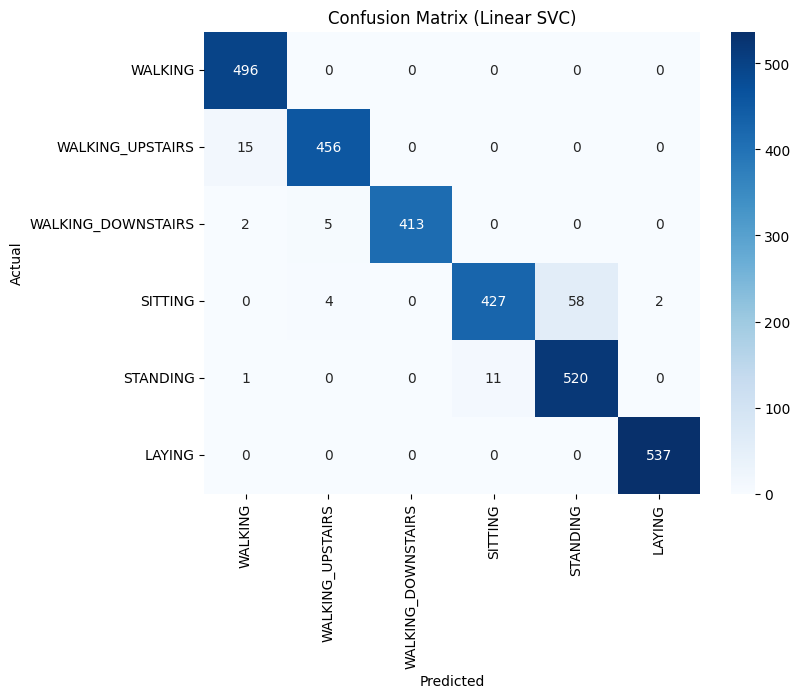

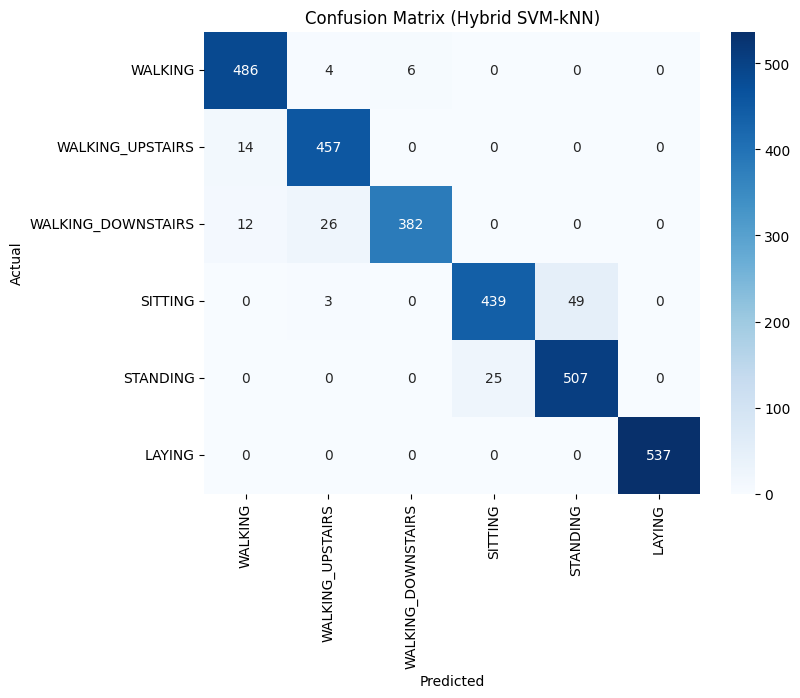

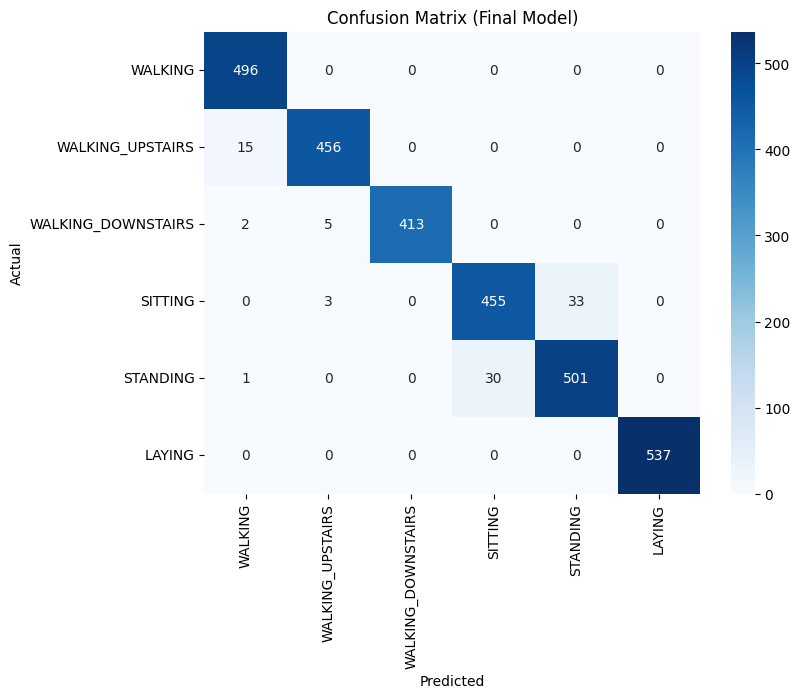

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
features = pd.read_csv('./dataset/UCI HAR Dataset/features.txt', sep='\s+', header=None, names=['index', 'feature'])
feature_names = features['feature'].values  # 특징 이름 배열

activity_labels = pd.read_csv('./dataset/UCI HAR Dataset/activity_labels.txt', sep='\s+', header=None, names=['label', 'activity'])
activity_mapping = dict(activity_labels.values)  # 활동 번호와 이름 매핑

train_data = pd.read_csv('./dataset/UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None)
train_labels = pd.read_csv('./dataset/UCI HAR Dataset/train/y_train.txt', header=None, names=['label'])

test_data = pd.read_csv('./dataset/UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None)
test_labels = pd.read_csv('./dataset/UCI HAR Dataset/test/y_test.txt', header=None, names=['label'])

# 특징 이름 추가
train_data.columns = feature_names
test_data.columns = feature_names

# 라벨 이름 추가
train_data['Activity'] = train_labels['label'].map(activity_mapping)
test_data['Activity'] = test_labels['label'].map(activity_mapping)

# 라벨 값 분리
y_train = train_labels['label'].values
y_test = test_labels['label'].values

# 특징 값만 선택
X_train = train_data.drop(columns=['Activity']).values
X_test = test_data.drop(columns=['Activity']).values

# 1번 방식: LinearSVC 모델
def linear_svc(X_train, y_train, X_test, y_test):
    model = LinearSVC(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred

# 6번 방식: Hybrid SVM-kNN 모델
def hybrid_svm_knn_v6(X_train, y_train, X_test, y_test, k=5, svm_threshold=0.7):
    # Step 1: k-NN 초기 필터링
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_labels = knn.predict(X_test)

    # Step 2: SVM 학습 및 예측
    svm = SVC(kernel='rbf', C=1, probability=True, random_state=42)  # RBF 커널 사용
    svm.fit(X_train, y_train)
    svm_probs = svm.predict_proba(X_test)  # 클래스별 확률
    svm_labels = svm.predict(X_test)

    # Step 3: SVM 신뢰도 기반 조합
    final_labels = []
    for i in range(len(y_test)):
        if max(svm_probs[i]) >= svm_threshold:
            final_labels.append(svm_labels[i])  # SVM 신뢰도가 기준 이상이면 SVM 결과 사용
        else:
            final_labels.append(knn_labels[i])  # 아니면 k-NN 결과 사용

    # 정확도 계산
    accuracy = accuracy_score(y_test, final_labels)
    return accuracy, final_labels

# Linear SVC 모델 평가
accuracy_svc, y_pred_svc = linear_svc(X_train, y_train, X_test, y_test)
print(f"Linear SVC 모델의 정확도: {accuracy_svc:.4f}")

# Hybrid SVM-kNN 모델 평가
accuracy_hybrid, final_labels_hybrid = hybrid_svm_knn_v6(X_train, y_train, X_test, y_test, k=5, svm_threshold=0.7)
print(f"Hybrid SVM-kNN 모델의 정확도: {accuracy_hybrid:.4f}")

# 최종 예측 결과 선택: Linear SVC와 Hybrid SVM-kNN
final_predictions = []

# LinearSVC 결과와 Hybrid SVM 결과 결합
for i in range(len(y_test)):
    if final_labels_hybrid[i] == 4:  # WALKING_UPSTAIRS의 레이블이 4라고 가정
        final_predictions.append(4)  # 하이브리드 모델이 WALKING_UPSTAIRS일 경우, 그 결과 채택
    else:
        final_predictions.append(y_pred_svc[i])  # LinearSVC 결과 채택

# 최종 정확도 계산
final_accuracy = accuracy_score(y_test, final_predictions)
print(f"최종 모델의 정확도: {final_accuracy:.4f}")

# 상세 성능 보고
print("\n분류 리포트:\n")
print(classification_report(y_test, final_predictions, target_names=activity_mapping.values()))

# 혼동 행렬 시각화: Linear SVC
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Linear SVC)')
plt.show()

# 혼동 행렬 시각화: Hybrid SVM-kNN
cm_hybrid = confusion_matrix(y_test, final_labels_hybrid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Hybrid SVM-kNN)')
plt.show()

# 혼동 행렬 시각화: 최종 모델
cm_final = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Final Model)')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
features = pd.read_csv('./dataset/UCI HAR Dataset/features.txt', sep='\\s+', header=None, names=['index', 'feature'])
feature_names = features['feature'].values  # 특징 이름 배열

activity_labels = pd.read_csv('./dataset/UCI HAR Dataset/activity_labels.txt', sep='\\s+', header=None, names=['label', 'activity'])
activity_mapping = dict(activity_labels.values)  # 활동 번호와 이름 매핑

train_data = pd.read_csv('./dataset/UCI HAR Dataset/train/X_train.txt', sep='\\s+', header=None)
train_labels = pd.read_csv('./dataset/UCI HAR Dataset/train/y_train.txt', header=None, names=['label'])

test_data = pd.read_csv('./dataset/UCI HAR Dataset/test/X_test.txt', sep='\\s+', header=None)
test_labels = pd.read_csv('./dataset/UCI HAR Dataset/test/y_test.txt', header=None, names=['label'])

# 특징 이름 추가
train_data.columns = feature_names
test_data.columns = feature_names

# 라벨 이름 추가
train_data['Activity'] = train_labels['label'].map(activity_mapping)
test_data['Activity'] = test_labels['label'].map(activity_mapping)

# 라벨 값 분리
y_train = train_labels['label'].values
y_test = test_labels['label'].values

# 특징 값만 선택
X_train = train_data.drop(columns=['Activity']).values
X_test = test_data.drop(columns=['Activity']).values

# LinearSVC 모델
model = LinearSVC(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear SVC 모델의 정확도: {accuracy:.4f}")

# 상세 성능 보고
print("\n분류 리포트:\n")
print(classification_report(y_test, y_pred, target_names=activity_mapping.values()))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Linear SVC)')
plt.show()


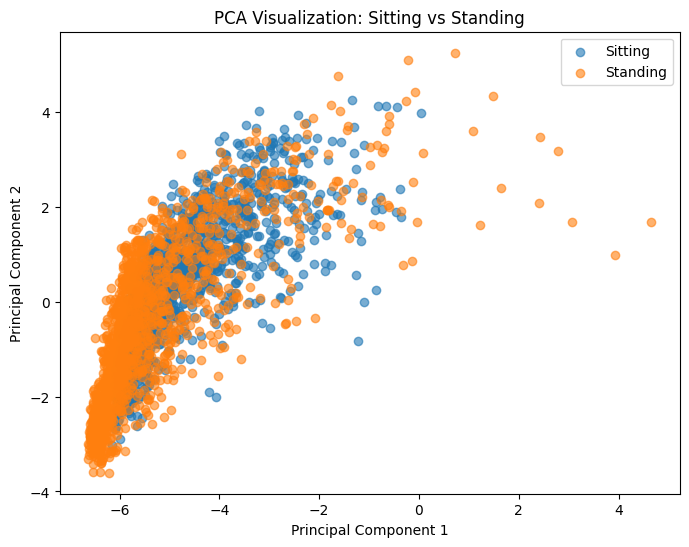

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# PCA를 사용하여 2차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Sitting과 Standing 데이터만 필터링
sitting_idx = (y_train == 5)  # Sitting 클래스
standing_idx = (y_train == 6)  # Standing 클래스

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[sitting_idx, 0], X_pca[sitting_idx, 1], label="Sitting", alpha=0.6)
plt.scatter(X_pca[standing_idx, 0], X_pca[standing_idx, 1], label="Standing", alpha=0.6)
plt.legend()
plt.title("PCA Visualization: Sitting vs Standing")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


SMOTE 적용 전 클래스 분포: [   0 1226 1073  986 1286 1374 1407]
SMOTE 적용 후 클래스 분포: [   0 1407 1407 1407 1407 1407 1407]
Linear SVC 모델의 정확도: 0.9657

분류 리포트:

                    precision    recall  f1-score   support

           WALKING       0.96      1.00      0.98       496
  WALKING_UPSTAIRS       0.98      0.96      0.97       471
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
           SITTING       0.98      0.87      0.92       491
          STANDING       0.90      0.98      0.94       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947



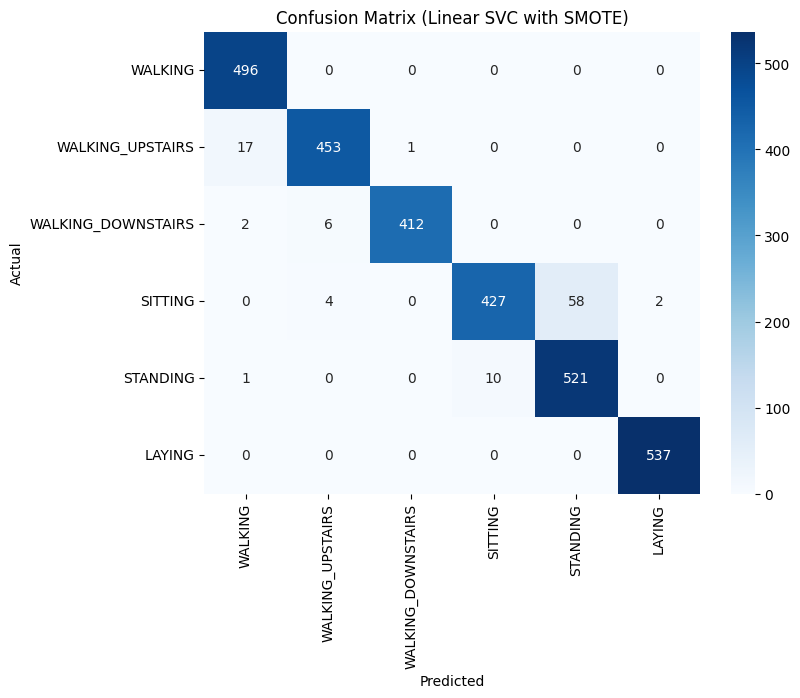


Standing 클래스 분류에 중요한 상위 10개 특성:

                         Feature  Coefficient
558         angle(X,gravityMean)     0.480057
57        tGravityAcc-energy()-Y     0.403827
58        tGravityAcc-energy()-Z     0.225642
142        tBodyGyro-entropy()-X     0.175240
159  tBodyGyro-correlation()-Y,Z     0.174336
455       fBodyGyro-kurtosis()-X     0.173045
37    tBodyAcc-correlation()-X,Y     0.168734
511          fBodyAccMag-maxInds     0.140401
190  tBodyGyroJerk-arCoeff()-Y,2     0.135052
38    tBodyAcc-correlation()-X,Z     0.132045


<ipython-input-25-4258fcf9bf55>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=important_features_standing.head(10), x='Coefficient', y='Feature', palette='viridis')


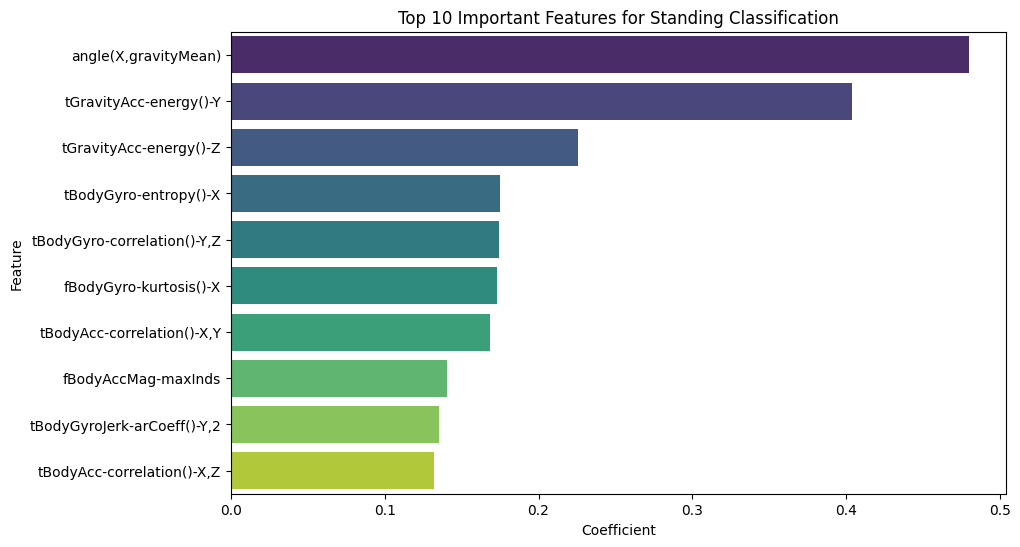


Sitting 클래스 분류에 중요한 상위 10개 특성:

                          Feature  Coefficient
89           tBodyAccJerk-max()-X     0.696290
92           tBodyAccJerk-min()-X     0.663948
24           tBodyAcc-entropy()-Z     0.646315
23           tBodyAcc-entropy()-Y     0.497549
171         tBodyGyroJerk-max()-Z     0.448979
489  fBodyGyro-bandsEnergy()-9,16     0.440049
376     fBodyAccJerk-kurtosis()-X     0.438711
9                tBodyAcc-max()-X     0.436100
28         tBodyAcc-arCoeff()-X,4     0.416923
91           tBodyAccJerk-max()-Z     0.390630


<ipython-input-25-4258fcf9bf55>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=important_features_sitting.head(10), x='Coefficient', y='Feature', palette='viridis')


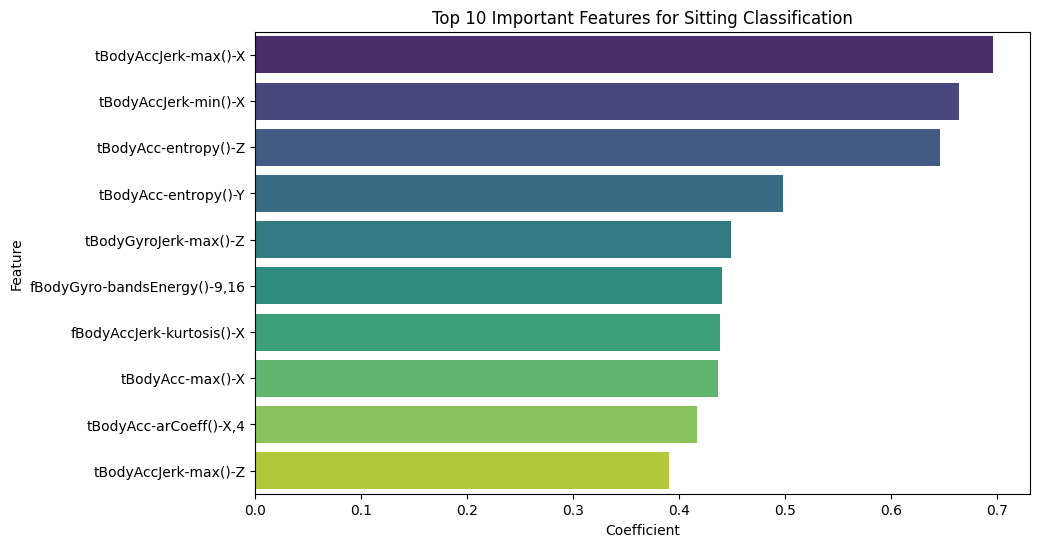

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
features = pd.read_csv('./dataset/UCI HAR Dataset/features.txt', sep='\\s+', header=None, names=['index', 'feature'])
feature_names = features['feature'].values  # 특징 이름 배열

activity_labels = pd.read_csv('./dataset/UCI HAR Dataset/activity_labels.txt', sep='\\s+', header=None, names=['label', 'activity'])
activity_mapping = dict(activity_labels.values)  # 활동 번호와 이름 매핑

train_data = pd.read_csv('./dataset/UCI HAR Dataset/train/X_train.txt', sep='\\s+', header=None)
train_labels = pd.read_csv('./dataset/UCI HAR Dataset/train/y_train.txt', header=None, names=['label'])

test_data = pd.read_csv('./dataset/UCI HAR Dataset/test/X_test.txt', sep='\\s+', header=None)
test_labels = pd.read_csv('./dataset/UCI HAR Dataset/test/y_test.txt', header=None, names=['label'])

# 특징 이름 추가
train_data.columns = feature_names
test_data.columns = feature_names

# 라벨 이름 추가
train_data['Activity'] = train_labels['label'].map(activity_mapping)
test_data['Activity'] = test_labels['label'].map(activity_mapping)

# 라벨 값 분리
y_train = train_labels['label'].values
y_test = test_labels['label'].values

# 특징 값만 선택
X_train = train_data.drop(columns=['Activity']).values
X_test = test_data.drop(columns=['Activity']).values

# SMOTE로 오버샘플링 적용
print("SMOTE 적용 전 클래스 분포:", np.bincount(y_train))
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 후 클래스 분포:", np.bincount(y_train_resampled))

# LinearSVC 모델
model = LinearSVC(random_state=42, max_iter=10000)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"Linear SVC 모델의 정확도: {accuracy:.4f}")

# 상세 성능 보고
print("\n분류 리포트:\n")
print(classification_report(y_test, y_pred, target_names=activity_mapping.values()))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Linear SVC with SMOTE)')
plt.show()

# Standing(6번 클래스)에 대한 중요한 특성 확인
standing_label = 6  # Standing 클래스 레이블
coefficients_standing = model.coef_[standing_label - 1]  # Linear SVC의 Standing 클래스에 대한 가중치 벡터
important_features_standing = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_standing
}).sort_values(by='Coefficient', ascending=False)

# 상위 10개 중요한 특성 출력
print("\nStanding 클래스 분류에 중요한 상위 10개 특성:\n")
print(important_features_standing.head(10))

# 중요한 특성 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=important_features_standing.head(10), x='Coefficient', y='Feature', palette='viridis')
plt.title('Top 10 Important Features for Standing Classification')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

# Sitting(3번 클래스)에 대한 중요한 특성 확인
sitting_label = 3  # Sitting 클래스 레이블
coefficients_sitting = model.coef_[sitting_label - 1]  # Linear SVC의 Sitting 클래스에 대한 가중치 벡터
important_features_sitting = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_sitting
}).sort_values(by='Coefficient', ascending=False)

# 상위 10개 중요한 특성 출력
print("\nSitting 클래스 분류에 중요한 상위 10개 특성:\n")
print(important_features_sitting.head(10))

# 중요한 특성 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=important_features_sitting.head(10), x='Coefficient', y='Feature', palette='viridis')
plt.title('Top 10 Important Features for Sitting Classification')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
features = pd.read_csv('./dataset/UCI HAR Dataset/features.txt', sep='\\s+', header=None, names=['index', 'feature'])
feature_names = features['feature'].values  # 특징 이름 배열

activity_labels = pd.read_csv('./dataset/UCI HAR Dataset/activity_labels.txt', sep='\\s+', header=None, names=['label', 'activity'])
activity_mapping = dict(activity_labels.values)  # 활동 번호와 이름 매핑

train_data = pd.read_csv('./dataset/UCI HAR Dataset/train/X_train.txt', sep='\\s+', header=None)
train_labels = pd.read_csv('./dataset/UCI HAR Dataset/train/y_train.txt', header=None, names=['label'])

test_data = pd.read_csv('./dataset/UCI HAR Dataset/test/X_test.txt', sep='\\s+', header=None)
test_labels = pd.read_csv('./dataset/UCI HAR Dataset/test/y_test.txt', header=None, names=['label'])

# 특징 이름 추가
train_data.columns = feature_names
test_data.columns = feature_names

# 라벨 이름 추가
train_data['Activity'] = train_labels['label'].map(activity_mapping)
test_data['Activity'] = test_labels['label'].map(activity_mapping)

# 라벨 값 분리
y_train = train_labels['label'].values
y_test = test_labels['label'].values

# 특징 값만 선택
X_train = train_data.drop(columns=['Activity']).values
X_test = test_data.drop(columns=['Activity']).values

# **Sitting(4)**과 **Standing(5)**을 구별하기 위한 모델 분리
# 이진 분류로 두 클래스를 분리하기 위해 필요한 데이터 필터링
train_sitting_standing = (y_train == 4) | (y_train == 5)  # Sitting(4)과 Standing(5)만 필터링
X_train_sitting_standing = X_train[train_sitting_standing]
y_train_sitting_standing = y_train[train_sitting_standing]

test_sitting_standing = (y_test == 4) | (y_test == 5)
X_test_sitting_standing = X_test[test_sitting_standing]
y_test_sitting_standing = y_test[test_sitting_standing]

# 모델 1: 기본 LinearSVC
model_linear_svc = LinearSVC(random_state=42)

# 모델 2: SVM with RBF kernel (Voting에 포함)
model_svm_rbf = SVC(kernel='rbf', random_state=42)

# **Sitting과 Standing을 위한 Voting Classifier** (이진 분류)
voting_clf_sitting_standing = VotingClassifier(estimators=[('linear_svc', model_linear_svc), ('svm_rbf', model_svm_rbf)], voting='hard')

# LinearSVC로 기본 훈련
model_linear_svc.fit(X_train, y_train)
y_pred_linear_svc = model_linear_svc.predict(X_test)

# Voting Classifier로 Sitting과 Standing 예측
voting_clf_sitting_standing.fit(X_train_sitting_standing, y_train_sitting_standing)
y_pred_sitting_standing = voting_clf_sitting_standing.predict(X_test_sitting_standing)

# 전체 예측 결합
final_pred = np.copy(y_pred_linear_svc)
final_pred[test_sitting_standing] = y_pred_sitting_standing

# 정확도 계산
accuracy = accuracy_score(y_test, final_pred)
print(f"최종 모델의 정확도: {accuracy:.4f}")

# 상세 성능 보고
print("\n분류 리포트:\n")
print(classification_report(y_test, final_pred, target_names=activity_mapping.values()))

# 혼동 행렬 시각화
cm_final = confusion_matrix(y_test, final_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (최종 모델)')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './dataset/UCI HAR Dataset/features.txt'

최종 모델의 정확도: 0.9695

분류 리포트:

                    precision    recall  f1-score   support

           WALKING       0.97      1.00      0.98       496
  WALKING_UPSTAIRS       0.99      0.97      0.98       471
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
           SITTING       0.93      0.93      0.93       491
          STANDING       0.94      0.93      0.94       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


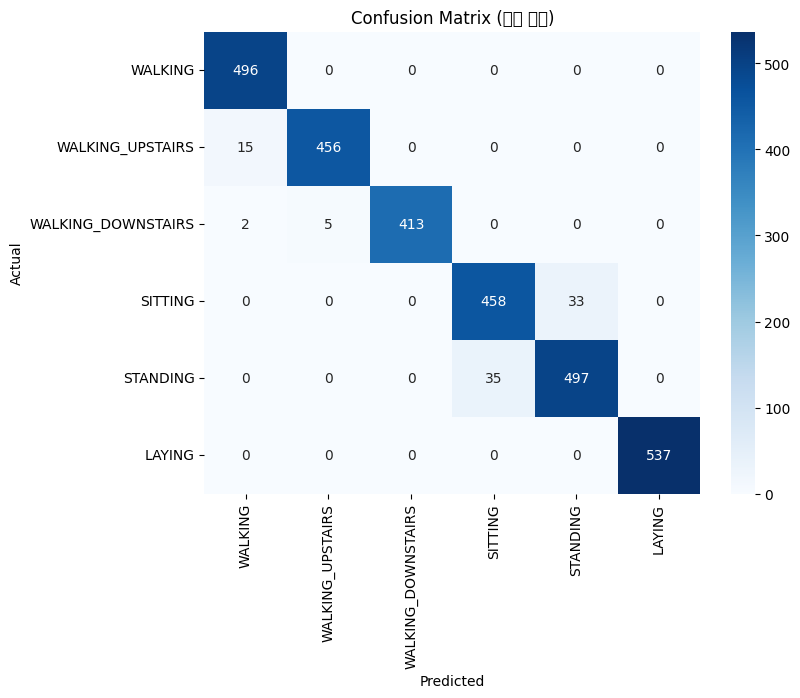

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
features = pd.read_csv('./dataset/UCI HAR Dataset/features.txt', sep='\\s+', header=None, names=['index', 'feature'])
feature_names = features['feature'].values  # 특징 이름 배열

activity_labels = pd.read_csv('./dataset/UCI HAR Dataset/activity_labels.txt', sep='\\s+', header=None, names=['label', 'activity'])
activity_mapping = dict(activity_labels.values)  # 활동 번호와 이름 매핑

train_data = pd.read_csv('./dataset/UCI HAR Dataset/train/X_train.txt', sep='\\s+', header=None)
train_labels = pd.read_csv('./dataset/UCI HAR Dataset/train/y_train.txt', header=None, names=['label'])

test_data = pd.read_csv('./dataset/UCI HAR Dataset/test/X_test.txt', sep='\\s+', header=None)
test_labels = pd.read_csv('./dataset/UCI HAR Dataset/test/y_test.txt', header=None, names=['label'])

# 특징 이름 추가
train_data.columns = feature_names
test_data.columns = feature_names

# 라벨 이름 추가
train_data['Activity'] = train_labels['label'].map(activity_mapping)
test_data['Activity'] = test_labels['label'].map(activity_mapping)

# 라벨 값 분리
y_train = train_labels['label'].values
y_test = test_labels['label'].values

# 특징 값만 선택
X_train = train_data.drop(columns=['Activity']).values
X_test = test_data.drop(columns=['Activity']).values

# **Sitting(4)**과 **Standing(5)**을 구별하기 위한 모델 분리
# 이진 분류로 두 클래스를 분리하기 위해 필요한 데이터 필터링
train_sitting_standing = (y_train == 4) | (y_train == 5)  # Sitting(4)과 Standing(5)만 필터링
X_train_sitting_standing = X_train[train_sitting_standing]
y_train_sitting_standing = y_train[train_sitting_standing]

test_sitting_standing = (y_test == 4) | (y_test == 5)
X_test_sitting_standing = X_test[test_sitting_standing]
y_test_sitting_standing = y_test[test_sitting_standing]

# 모델 정의
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_svm_rbf = SVC(kernel='rbf', random_state=42)
model_linear_svc = LinearSVC(random_state=42)

# Voting Classifier 정의 (hard voting)
voting_clf = VotingClassifier(estimators=[
    ('rf', model_rf),
    ('svm_rbf', model_svm_rbf),
    ('linear_svc', model_linear_svc)
], voting='hard')

# LinearSVC로 전체 훈련
model_linear_svc.fit(X_train, y_train)
y_pred_linear_svc = model_linear_svc.predict(X_test)

# Voting Classifier로 Sitting과 Standing 예측
voting_clf_sitting_standing.fit(X_train_sitting_standing, y_train_sitting_standing)
y_pred_sitting_standing = voting_clf_sitting_standing.predict(X_test_sitting_standing)

# 전체 예측 결합
final_pred = np.copy(y_pred_linear_svc)
final_pred[test_sitting_standing] = y_pred_sitting_standing

# 정확도 계산
accuracy = accuracy_score(y_test, final_pred)
print(f"최종 모델의 정확도: {accuracy:.4f}")

# 상세 성능 보고
print("\n분류 리포트:\n")
print(classification_report(y_test, final_pred, target_names=activity_mapping.values()))

# 혼동 행렬 시각화
cm_final = confusion_matrix(y_test, final_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.values(), yticklabels=activity_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (최종 모델)')
plt.show()


Voting Classifier 정확도: 0.9355

Voting Classifier 성능 보고:
              precision    recall  f1-score   support

     Sitting       0.95      0.91      0.93       491
    Standing       0.92      0.96      0.94       532

    accuracy                           0.94      1023
   macro avg       0.94      0.93      0.94      1023
weighted avg       0.94      0.94      0.94      1023



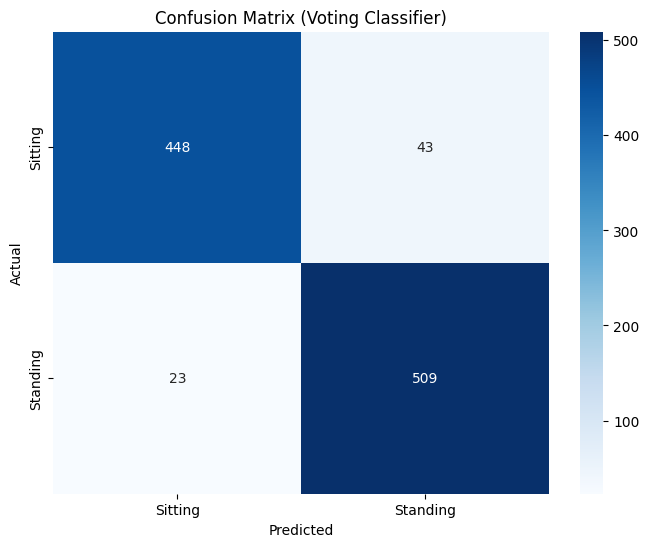

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리
features = pd.read_csv('./dataset/UCI HAR Dataset/features.txt', sep='\\s+', header=None, names=['index', 'feature'])
feature_names = features['feature'].values  # 특징 이름 배열

activity_labels = pd.read_csv('./dataset/UCI HAR Dataset/activity_labels.txt', sep='\\s+', header=None, names=['label', 'activity'])
activity_mapping = dict(activity_labels.values)  # 활동 번호와 이름 매핑

train_data = pd.read_csv('./dataset/UCI HAR Dataset/train/X_train.txt', sep='\\s+', header=None)
train_labels = pd.read_csv('./dataset/UCI HAR Dataset/train/y_train.txt', header=None, names=['label'])

test_data = pd.read_csv('./dataset/UCI HAR Dataset/test/X_test.txt', sep='\\s+', header=None)
test_labels = pd.read_csv('./dataset/UCI HAR Dataset/test/y_test.txt', header=None, names=['label'])

# 특징 이름 추가
train_data.columns = feature_names
test_data.columns = feature_names

# 라벨 이름 추가
train_data['Activity'] = train_labels['label'].map(activity_mapping)
test_data['Activity'] = test_labels['label'].map(activity_mapping)

# 라벨 값 분리
y_train = train_labels['label'].values
y_test = test_labels['label'].values

# 특징 값만 선택
X_train = train_data.drop(columns=['Activity']).values
X_test = test_data.drop(columns=['Activity']).values

# **Sitting(4)**과 **Standing(5)**을 구별하기 위한 모델 분리
train_sitting_standing = (y_train == 4) | (y_train == 5)  # Sitting(4)과 Standing(5)만 필터링
X_train_sitting_standing = X_train[train_sitting_standing]
y_train_sitting_standing = y_train[train_sitting_standing]

test_sitting_standing = (y_test == 4) | (y_test == 5)
X_test_sitting_standing = X_test[test_sitting_standing]
y_test_sitting_standing = y_test[test_sitting_standing]

# 모델 정의
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_svm_rbf = SVC(kernel='rbf', random_state=42)
model_linear_svc = LinearSVC(random_state=42)

# Voting Classifier 정의 (hard voting)
voting_clf = VotingClassifier(estimators=[
    ('rf', model_rf),
    ('svm_rbf', model_svm_rbf),
    ('linear_svc', model_linear_svc)
], voting='hard')

# 모델 훈련
voting_clf.fit(X_train_sitting_standing, y_train_sitting_standing)

# 예측
y_pred_voting = voting_clf.predict(X_test_sitting_standing)

# 성능 평가
accuracy = accuracy_score(y_test_sitting_standing, y_pred_voting)
print(f"Voting Classifier 정확도: {accuracy:.4f}")

# 분류 리포트 (Sitting과 Standing에 대한 성능)
print("\nVoting Classifier 성능 보고:")
print(classification_report(y_test_sitting_standing, y_pred_voting, target_names=['Sitting', 'Standing']))

# 혼동 행렬 시각화
cm_voting = confusion_matrix(y_test_sitting_standing, y_pred_voting)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues', xticklabels=['Sitting', 'Standing'], yticklabels=['Sitting', 'Standing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Voting Classifier)')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 데이터 로드 (UCI HAR 데이터셋 예시)
features = pd.read_csv('./dataset/UCI HAR Dataset/features.txt', sep='\\s+', header=None, names=['index', 'feature'])
feature_names = features['feature'].values  # 특징 이름 배열

activity_labels = pd.read_csv('./dataset/UCI HAR Dataset/activity_labels.txt', sep='\\s+', header=None, names=['label', 'activity'])
activity_mapping = dict(activity_labels.values)  # 활동 번호와 이름 매핑

train_data = pd.read_csv('./dataset/UCI HAR Dataset/train/X_train.txt', sep='\\s+', header=None)
train_labels = pd.read_csv('./dataset/UCI HAR Dataset/train/y_train.txt', header=None, names=['label'])

test_data = pd.read_csv('./dataset/UCI HAR Dataset/test/X_test.txt', sep='\\s+', header=None)
test_labels = pd.read_csv('./dataset/UCI HAR Dataset/test/y_test.txt', header=None, names=['label'])

# 특징 이름 추가
train_data.columns = feature_names
test_data.columns = feature_names

# 라벨 이름 추가
train_data['Activity'] = train_labels['label'].map(activity_mapping)
test_data['Activity'] = test_labels['label'].map(activity_mapping)

# 라벨 값 분리
y_train = train_labels['label'].values
y_test = test_labels['label'].values

# 특징 값만 선택
X_train = train_data.drop(columns=['Activity']).values
X_test = test_data.drop(columns=['Activity']).values

# 데이터 전처리 (스케일링)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 개별 모델 정의
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_gbm = GradientBoostingClassifier(random_state=42)
model_knn = KNeighborsClassifier(n_neighbors=5)
model_svc = SVC(kernel='rbf', random_state=42)
model_logreg = LogisticRegression(random_state=42)

# Stacking Classifier 정의 (최종 예측을 위한 모델로 Logistic Regression 사용)
stacking_clf = StackingClassifier(estimators=[
    ('rf', model_rf),
    ('gbm', model_gbm),
    ('knn', model_knn),
    ('svc', model_svc)
], final_estimator=model_logreg)

# 모델 훈련
stacking_clf.fit(X_train_scaled, y_train)

# 예측
y_pred_stacking = stacking_clf.predict(X_test_scaled)

# 성능 평가
accuracy = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Classifier 정확도: {accuracy:.4f}")

# 분류 리포트 출력
print("\nStacking Classifier 성능 보고:")
print(classification_report(y_test, y_pred_stacking))

# 혼동 행렬 시각화
cm_final = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Stacking Classifier)')
plt.show()


KeyboardInterrupt: 